## Nation-Wide Data Science Jobscape

In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from splinter import Browser
import scrapy

In [2]:
# NLTK
#!pip install nltk
import nltk
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.tag import pos_tag
from nltk.probability import FreqDist

In [5]:
#Plotly
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# base_url = f'https://www.onetonline.org/link/localjobs/15-2051.00?st={state}'

In [3]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
            'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
            'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
            'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
            'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

In [3]:
len(states)

50

### Test

In [4]:
AL = pd.read_html(f'https://www.onetonline.org/link/localjobs/15-2051.00?st={states[1]}')
AL[0].head(5)

,Posted,Title and Company,Location
0,"June 13, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"
1,"May 26, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"
2,"May 19, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"
3,"June 3, 2023",Senior Data ScientistPearson,"Juneau, AK"
4,"June 13, 2023",AI Senior Data ScientistTravelers Insurance Co...,"Juneau, AK"


In [5]:
TABLES = []
for i in states:
    table = pd.read_html(f'https://www.onetonline.org/link/localjobs/15-2051.00?st={i}')
    TABLES.append(table[0])
TABLES

[            Posted                                  Title and Company  \
 0     June 8, 2023                           Data ScientistISSAC Corp   
 1    June 14, 2023                Data ScientistSOS International LLC   
 2    June 10, 2023                               Data ScientistAxient   
 3     June 9, 2023                    Data ScientistNou Systems, Inc.   
 4     May 18, 2023                           Data ScientistGuidehouse   
 5     May 18, 2023  Data Scientist and Applied MathematicianBooz A...   
 6     June 1, 2023                      Lead NLP Data ScientistHumana   
 7     June 4, 2023                      Lead NLP Data ScientistHumana   
 8    June 13, 2023              Data Scientist, Product AnalyticsMeta   
 9     May 26, 2023              Data Scientist, Product AnalyticsMeta   
 10    May 19, 2023              Data Scientist, Product AnalyticsMeta   
 11    June 3, 2023                       Senior Data ScientistPearson   
 12   June 13, 2023  AI Senior Data Sc

In [6]:
df = pd.DataFrame()
for table in TABLES:
    df = pd.concat([df, table], axis=0)
df

,Posted,Title and Company,Location
0,"June 8, 2023",Data ScientistISSAC Corp,"Huntsville, AL"
1,"June 14, 2023",Data ScientistSOS International LLC,"Redstone Arsenal, AL"
2,"June 10, 2023",Data ScientistAxient,"Huntsville, AL"
3,"June 9, 2023","Data ScientistNou Systems, Inc.","Huntsville, AL"
4,"May 18, 2023",Data ScientistGuidehouse,"Huntsville, AL"
...,...,...,...
31,"June 14, 2023",Senior Principal Applied Scientist-OCI AIOracle,"Cheyenne, WY"
32,"June 7, 2023",Principal Applied Scientist-OCI AI ServicesOracle,"Cheyenne, WY"
33,"June 8, 2023",Data Analytics ConsultantGuidehouse,"Cheyenne, WY"
34,"May 24, 2023","Director, Data Science - Fraud DetectionTravel...","Cheyenne, WY"


In [7]:
# Split the field at the point where lowercase and uppercase letters meet
pattern = r'(?<=[a-z])(?=[A-Z])'
df[['Title', 'Company']] = df['Title and Company'].str.split(pattern, n=1, expand=True)

# Remove any leading/trailing whitespaces
df['Title'] = df['Title'].str.strip()
df['Company'] = df['Company'].str.strip()

# Drop the 'Title and Company' Field
df.drop('Title and Company', axis=1, inplace=True)

# Split the Location field at the comma to create a City and State field
df[['City', 'State']] = df['Location'].str.split(',', n=1, expand=True)

# Remove any leading/trailing whitespace on the State and City fields values
df['State'] = df['State'].str.strip()
df['City'] = df['City'].str.strip()

# Do not drop the Location column in case of need for combined field while Mapping

# Reorder columns
df = df[['State', 'City', 'Title', 'Company', 'Posted', 'Location']]

# Inspect resulting df
df

,State,City,Title,Company,Posted,Location
0,AL,Huntsville,Data Scientist,ISSAC Corp,"June 8, 2023","Huntsville, AL"
1,AL,Redstone Arsenal,Data Scientist,SOS International LLC,"June 14, 2023","Redstone Arsenal, AL"
2,AL,Huntsville,Data Scientist,Axient,"June 10, 2023","Huntsville, AL"
3,AL,Huntsville,Data Scientist,"Nou Systems, Inc.","June 9, 2023","Huntsville, AL"
4,AL,Huntsville,Data Scientist,Guidehouse,"May 18, 2023","Huntsville, AL"
...,...,...,...,...,...,...
31,WY,Cheyenne,Senior Principal Applied Scientist-OCI AIOracle,None,"June 14, 2023","Cheyenne, WY"
32,WY,Cheyenne,Principal Applied Scientist-OCI AI Services,Oracle,"June 7, 2023","Cheyenne, WY"
33,WY,Cheyenne,Data Analytics Consultant,Guidehouse,"June 8, 2023","Cheyenne, WY"
34,WY,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"


In [8]:
df.to_csv('Data/us_ds_jobs.csv', index=False)

### Discover the top 15 most frequently used titles in the country

In [12]:
# Plot the top five titles by state using Plotlu
top_15 = df['Title'].value_counts().head(15)
top_15

Data Scientist, Product Analytics                       250
Data Scientist, Product Analytics - Monetization        152
Data Scientist                                          138
Senior Data Scientist                                   129
Lead NLP Data Scientist                                 102
Data Engineer                                            96
Research Scientist, Machine Learning (Ph                 76
Data Scientist, Product - Generative AIMeta              76
Data Scientist, Product Analytics - Machine Learning     76
Data Scientist, Product Analytics - Reality Labs         74
Labs - Data Scientist - Senior Associate                 66
Senior Data Scientist I (Remote)RELX INC                 54
Data Scientist (Hybrid / Remote)UMB Bank                 53
Director & Data Scientist                                51
AI Senior Data Scientist                                 51
Name: Title, dtype: int64

In [13]:
# Convert the value counts to a dataframe
top_15_df = pd.DataFrame(top_15)

In [17]:
# Import dfi to export dataframe as image
import dataframe_image as dfi

# Export df as image
dfi.export(top_15_df, 'top_15_titles.png')

### Read in CSV

In [4]:
df = pd.read_csv('Data/us_ds_jobs.csv')
df

,State,City,Title,Company,Posted,Location
0,AL,Huntsville,Data Scientist,ISSAC Corp,"June 8, 2023","Huntsville, AL"
1,AL,Redstone Arsenal,Data Scientist,SOS International LLC,"June 14, 2023","Redstone Arsenal, AL"
2,AL,Huntsville,Data Scientist,Axient,"June 10, 2023","Huntsville, AL"
3,AL,Huntsville,Data Scientist,"Nou Systems, Inc.","June 9, 2023","Huntsville, AL"
4,AL,Huntsville,Data Scientist,Guidehouse,"May 18, 2023","Huntsville, AL"
...,...,...,...,...,...,...
2534,WY,Cheyenne,Senior Principal Applied Scientist-OCI AIOracle,NaN,"June 14, 2023","Cheyenne, WY"
2535,WY,Cheyenne,Principal Applied Scientist-OCI AI Services,Oracle,"June 7, 2023","Cheyenne, WY"
2536,WY,Cheyenne,Data Analytics Consultant,Guidehouse,"June 8, 2023","Cheyenne, WY"
2537,WY,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"


### Inspect Titles

In [5]:
title_vc = df['Title'].value_counts()
title_vc

Data Scientist, Product Analytics                                                                                          250
Data Scientist, Product Analytics - Monetization                                                                           152
Data Scientist                                                                                                             138
Senior Data Scientist                                                                                                      129
Lead NLP Data Scientist                                                                                                    102
                                                                                                                          ... 
DATA SCIENTISTDefense Intelligence Agency                                                                                    1
IC21D3 - Sr Data Scientist - Cleared                                                                           

In [6]:
# Define job_titles
job_titles = df['Title']

In [7]:
# Get unique titles
unique_titles = job_titles.unique()
print(f'There are {len(unique_titles)} unique Data Science-Related Job Titles currently posted in the U.S. on O*NET OnLine.')
unique_titles[0:5]

There are 426 unique Data Science-Related Job Titles currently posted in the U.S. on O*NET OnLine.


array(['Data Scientist', 'Data Scientist and Applied Mathematician',
       'Lead NLP Data Scientist', 'Data Scientist, Product Analytics',
       'Senior Data Scientist'], dtype=object)

### Define job title parsing function with NLTK

In [8]:
def parse_job_titles(job_titles):
    # Load the Punkt tokenizer for sentence tokenization
    sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    # Tokenize each job title and perform part-of-speech tagging
    parsed_titles = []
    for title in job_titles:
        sentences = sentence_tokenizer.tokenize(title)
        for sentence in sentences:
            words = word_tokenize(sentence)
            tagged_words = pos_tag(words)
            parsed_titles.append(tagged_words)

    return parsed_titles

In [9]:
# Parse the job titles
parsed_job_titles = parse_job_titles(job_titles)

In [10]:
parsed_job_titles[0]

[('Data', 'NNS'), ('Scientist', 'NN')]

In [11]:
# Extract job categories from parsed titles
job_categories = []
for parsed_title in parsed_job_titles:
    for word, tag in parsed_title:
        if tag == 'NN' or tag.startswith('NNS'):
            job_categories.append(word.lower())

# Create frequency distribution of job categories
freq_dist = FreqDist(job_categories)

# Print the most common job categories
most_common_categories = freq_dist.most_common(10)
for category, count in most_common_categories:
    print(f"{category}: {count} occurrences")

scientist: 550 occurrences
data: 337 occurrences
monetization: 152 occurrences
machine: 94 occurrences
aimeta: 76 occurrences
reality: 74 occurrences
mlphumana: 47 occurrences
detection: 46 occurrences
remote: 30 occurrences
analytics: 19 occurrences


### Parse job titles for each State in DataFrame

In [12]:
# Create an empty dictionary to store the frequency distributions
state_freq_dists = {}

# Iterate over unique states in the DataFrame
for state in df['State'].unique():
    # Filter job titles for the current state
    job_titles_state = df.loc[df['State'] == state, 'Title']

    # Parse the job titles for the current state
    parsed_job_titles_state = parse_job_titles(job_titles_state)

    # Extract job categories from parsed titles
    job_categories_state = []
    for parsed_title in parsed_job_titles_state:
        for word, tag in parsed_title:
            if tag == 'NN' or tag.startswith('NNS'):
                job_categories_state.append(word.lower())

    # Create frequency distribution for the current state
    freq_dist_state = FreqDist(job_categories_state)

    # Store the frequency distribution in the dictionary
    state_freq_dists[state] = freq_dist_state

# Print the frequency distributions for each state
for state, freq_dist in state_freq_dists.items():
    print(f"State: {state}")
    print(freq_dist.most_common(5))  # Print most common categories for each state
    print()

State: AL
[('scientist', 10), ('data', 8), ('monetization', 2), ('aimeta', 1), ('machine', 1)]

State: AK
[('scientist', 3), ('data', 2), ('monetization', 2), ('aimeta', 1), ('machine', 1)]

State: AZ
[('scientist', 8), ('data', 5), ('monetization', 2), ('foods', 2), ('company', 2)]

State: AR
[('scientist', 10), ('data', 5), ('monetization', 2), ('aimeta', 1), ('machine', 1)]

State: CA
[('scientist', 27), ('data', 17), ('monetization', 5), ('machine', 4), ('aimeta', 2)]

State: CO
[('scientist', 10), ('data', 8), ('pricing', 2), ('monetization', 2), ('analytics', 2)]

State: CT
[('scientist', 6), ('data', 4), ('monetization', 2), ('aimeta', 1), ('machine', 1)]

State: nan
[]

State: DE
[('scientist', 5), ('data', 2), ('monetization', 2), ('aimeta', 1), ('machine', 1)]

State: FL
[('scientist', 16), ('data', 13), ('remote', 2), ('monetization', 2), ('aimeta', 1)]

State: GA
[('scientist', 11), ('data', 5), ('monetization', 2), ('intuit', 1), ('scientists', 1)]

State: HI
[('scientist'

In [13]:
# Convert frequency distributions to a DataFrame
df_freq_dists = pd.DataFrame(state_freq_dists).fillna(0).astype(int)

df_freq_dists

,AL,AK,AZ,AR,CA,CO,CT,NaN,DE,FL,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
data,8,2,5,5,17,8,4,0,2,13,...,18,4,3,33,3,9,7,0,7,2
scientist,10,3,8,10,27,10,6,0,5,16,...,23,11,5,48,10,15,12,0,11,5
aimeta,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,3,1,0,2,2
machine,1,1,1,1,4,1,1,0,1,1,...,3,5,2,0,2,3,1,0,2,2
monetization,2,2,2,2,5,2,2,0,2,2,...,4,4,4,0,4,5,2,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
capabilities,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
customer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
obsession,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
atgservice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [14]:
# Drop 'data' and 'scientist' for more meaningful analysis
df_freq_dists_drop_ds = df_freq_dists.drop(df_freq_dists.index[:2])
df_freq_dists_drop_ds

,AL,AK,AZ,AR,CA,CO,CT,NaN,DE,FL,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
aimeta,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,3,1,0,2,2
machine,1,1,1,1,4,1,1,0,1,1,...,3,5,2,0,2,3,1,0,2,2
monetization,2,2,2,2,5,2,2,0,2,2,...,4,4,4,0,4,5,2,0,4,4
reality,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,2,1,0,2,2
remote,1,0,1,1,0,1,0,0,1,2,...,1,0,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
capabilities,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
customer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
obsession,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
atgservice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [20]:
# Top nine with 'data' and 'scientist'
top = df_freq_dists.iloc[0:9,:]
top


,AL,AK,AZ,AR,CA,CO,CT,NaN,DE,FL,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
data,8,2,5,5,17,8,4,0,2,13,...,18,4,3,33,3,9,7,0,7,2
scientist,10,3,8,10,27,10,6,0,5,16,...,23,11,5,48,10,15,12,0,11,5
aimeta,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,3,1,0,2,2
machine,1,1,1,1,4,1,1,0,1,1,...,3,5,2,0,2,3,1,0,2,2
monetization,2,2,2,2,5,2,2,0,2,2,...,4,4,4,0,4,5,2,0,4,4
reality,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,2,1,0,2,2
remote,1,0,1,1,0,1,0,0,1,2,...,1,0,0,0,1,1,1,0,0,0
mlphumana,1,0,1,1,1,1,1,0,1,1,...,1,1,1,0,1,0,0,0,1,1
detection,1,1,1,1,0,0,1,0,1,1,...,1,1,1,0,1,0,0,0,1,1


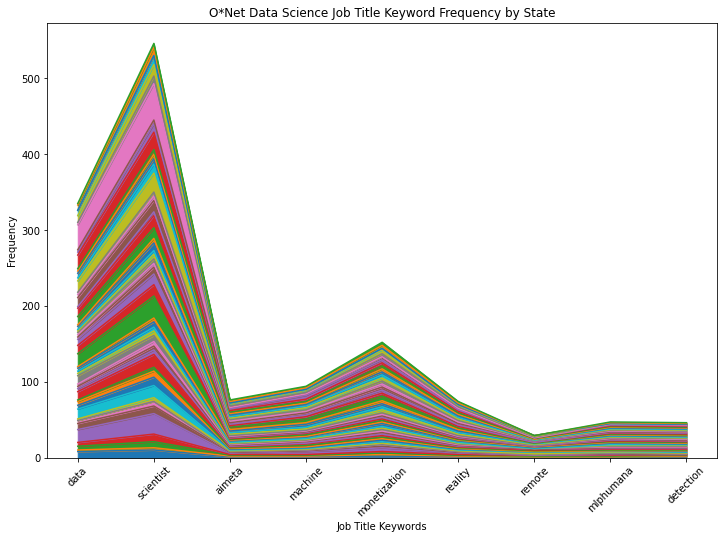

In [35]:
# Stacked Area Plot (including 'data' and 'scientist')
top.plot(kind='area', stacked=True, legend=False, figsize=[12,8])
plt.xlabel('Job Title Keywords')
plt.ylabel('Frequency')
plt.title('O*Net Data Science Job Title Keyword Frequency by State')

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)
plt.savefig('Figures/ds_job_title_category_area_plot.png')
plt.show()

In [21]:
# Top nine without 'data' and 'scientist'
top_nine = df_freq_dists_drop_ds.iloc[0:8,:]
top_nine

,AL,AK,AZ,AR,CA,CO,CT,NaN,DE,FL,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
aimeta,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,3,1,0,2,2
machine,1,1,1,1,4,1,1,0,1,1,...,3,5,2,0,2,3,1,0,2,2
monetization,2,2,2,2,5,2,2,0,2,2,...,4,4,4,0,4,5,2,0,4,4
reality,1,1,1,1,2,1,1,0,1,1,...,2,2,2,0,2,2,1,0,2,2
remote,1,0,1,1,0,1,0,0,1,2,...,1,0,0,0,1,1,1,0,0,0
mlphumana,1,0,1,1,1,1,1,0,1,1,...,1,1,1,0,1,0,0,0,1,1
detection,1,1,1,1,0,0,1,0,1,1,...,1,1,1,0,1,0,0,0,1,1
marketing,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


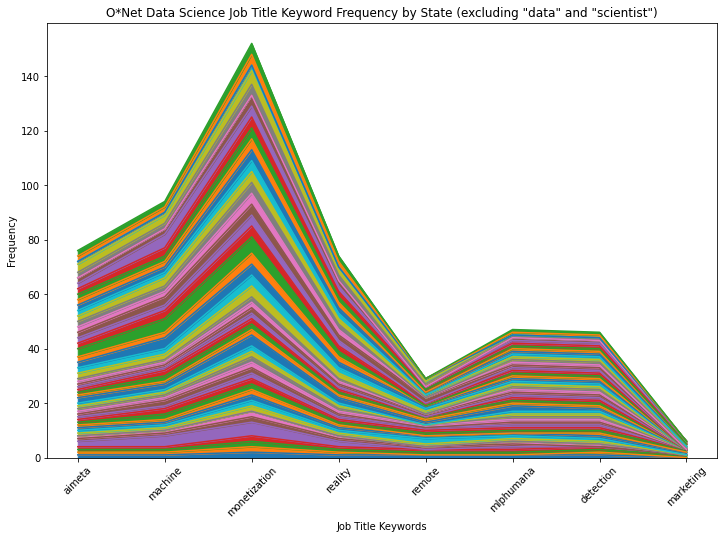

In [34]:
# Stacked Area Plot
top_nine.plot(kind='area', stacked=True, legend=False, figsize=[12,8])
plt.xlabel('Job Title Keywords')
plt.ylabel('Frequency')
plt.title('O*Net Data Science Job Title Keyword Frequency by State (excluding "data" and "scientist")')

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)
plt.savefig('Figures/no_ds_job_title_category_area_plot.png')
plt.show()

### Note for future work: Go back and remove 'Data' and 'Scientist' from all the job titles that don't only contain 'Data Scientist', then run the script again.

## Analyze for regional differences

In [24]:
df = pd.read_csv('Data/us_ds_jobs.csv')
df

,State,City,Title,Company,Posted,Location
0,AL,Huntsville,Data Scientist,ISSAC Corp,"June 8, 2023","Huntsville, AL"
1,AL,Redstone Arsenal,Data Scientist,SOS International LLC,"June 14, 2023","Redstone Arsenal, AL"
2,AL,Huntsville,Data Scientist,Axient,"June 10, 2023","Huntsville, AL"
3,AL,Huntsville,Data Scientist,"Nou Systems, Inc.","June 9, 2023","Huntsville, AL"
4,AL,Huntsville,Data Scientist,Guidehouse,"May 18, 2023","Huntsville, AL"
...,...,...,...,...,...,...
2534,WY,Cheyenne,Senior Principal Applied Scientist-OCI AIOracle,NaN,"June 14, 2023","Cheyenne, WY"
2535,WY,Cheyenne,Principal Applied Scientist-OCI AI Services,Oracle,"June 7, 2023","Cheyenne, WY"
2536,WY,Cheyenne,Data Analytics Consultant,Guidehouse,"June 8, 2023","Cheyenne, WY"
2537,WY,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"


In [25]:
# Drop rows with NA values in a specific column
df = df.dropna(subset=['State'])
df.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'MO', 'KY', 'LA', 'NV', 'ME', 'MD',
       'MA', 'MI', 'MN', 'MS', 'MT', 'NE', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WV', 'WA', 'DC', 'D.C.', 'WI', 'WY'], dtype=object)

In [26]:
df.shape

(2533, 6)

In [27]:
regions_df = pd.read_csv('Data/state_region.csv')
regions_df = regions_df.rename(columns={'State': 'State Name', 'State Code': 'State'})
regions_df.State.unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [28]:
df2 = pd.merge(regions_df, df, on='State', how='outer')
df2

,State Name,State,Region,Division,City,Title,Company,Posted,Location
0,Alaska,AK,West,Pacific,Juneau,"Data Scientist, Product Analytics",Meta,"June 13, 2023","Juneau, AK"
1,Alaska,AK,West,Pacific,Juneau,"Data Scientist, Product Analytics",Meta,"May 26, 2023","Juneau, AK"
2,Alaska,AK,West,Pacific,Juneau,"Data Scientist, Product Analytics",Meta,"May 19, 2023","Juneau, AK"
3,Alaska,AK,West,Pacific,Juneau,Senior Data Scientist,Pearson,"June 3, 2023","Juneau, AK"
4,Alaska,AK,West,Pacific,Juneau,AI Senior Data Scientist,Travelers Insurance Company,"June 13, 2023","Juneau, AK"
...,...,...,...,...,...,...,...,...,...
2528,Wyoming,WY,West,Mountain,Cheyenne,Principal Applied Scientist-OCI AI Services,Oracle,"June 7, 2023","Cheyenne, WY"
2529,Wyoming,WY,West,Mountain,Cheyenne,Data Analytics Consultant,Guidehouse,"June 8, 2023","Cheyenne, WY"
2530,Wyoming,WY,West,Mountain,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"
2531,Wyoming,WY,West,Mountain,Cheyenne,Data Engineer I - Data Modeler,Travelers Insurance Company,"May 20, 2023","Cheyenne, WY"


### Modify earlier code to run by Region

In [29]:
# Create an empty dictionary to store the frequency distributions
region_freq_dists = {}

# Iterate over unique states in the DataFrame
for region in df2['Region'].unique():
    # Filter job titles for the current state
    job_titles_region = df2.loc[df2['Region'] == region, 'Title']

    # Parse the job titles for the current state
    parsed_job_titles_region = parse_job_titles(job_titles_region)

    # Extract job categories from parsed titles
    job_categories_region = []
    for parsed_title in parsed_job_titles_region:
        for word, tag in parsed_title:
            if tag == 'NN' or tag.startswith('NNS'):
                job_categories_region.append(word.lower())

    # Create frequency distribution for the current state
    freq_dist_region = FreqDist(job_categories_region)

    # Store the frequency distribution in the dictionary
    region_freq_dists[region] = freq_dist_region

# Print the frequency distributions for each state
for region, freq_dist in region_freq_dists.items():
    print(f"Region: {region}")
    print(freq_dist.most_common(10))  # Print most common categories for each state
    print()

Region: West
[('scientist', 116), ('data', 66), ('monetization', 42), ('machine', 27), ('aimeta', 21), ('reality', 20), ('mlphumana', 11), ('detection', 10), ('remote', 5), ('marketing', 3)]

Region: South
[('scientist', 225), ('data', 144), ('monetization', 44), ('machine', 25), ('aimeta', 22), ('reality', 22), ('mlphumana', 15), ('detection', 15), ('remote', 13), ('hybrid', 5)]

Region: Northeast
[('scientist', 97), ('data', 56), ('monetization', 32), ('machine', 22), ('aimeta', 16), ('reality', 15), ('mlphumana', 9), ('detection', 9), ('analytics', 5), ('remote', 4)]

Region: Midwest
[('scientist', 108), ('data', 69), ('monetization', 34), ('machine', 20), ('aimeta', 17), ('reality', 17), ('mlphumana', 12), ('detection', 12), ('analytics', 8), ('remote', 7)]

Region: nan
[]



In [30]:
# Convert frequency distributions to a DataFrame
df_region_freq_dist = pd.DataFrame(region_freq_dists).fillna(0).astype(int)
df_region_freq_dist.head(9)

,West,South,Northeast,Midwest,NaN
scientist,116,225,97,108,0
data,66,144,56,69,0
aimeta,21,22,16,17,0
machine,27,25,22,20,0
monetization,42,44,32,34,0
reality,20,22,15,17,0
detection,10,15,9,12,0
remote,5,13,4,7,0
marketing,3,3,0,0,0


In [31]:
region_categories = df_region_freq_dist.iloc[0:9,0:4]
region_categories

,West,South,Northeast,Midwest
scientist,116,225,97,108
data,66,144,56,69
aimeta,21,22,16,17
machine,27,25,22,20
monetization,42,44,32,34
reality,20,22,15,17
detection,10,15,9,12
remote,5,13,4,7
marketing,3,3,0,0


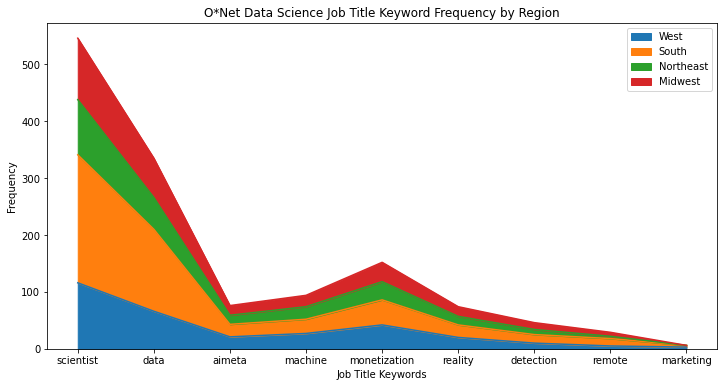

In [33]:
# Stacked Area Plot
region_categories.plot(kind='area', stacked=True, legend=True, figsize=[12,6])
plt.xlabel('Job Title Keywords')
plt.ylabel('Frequency')
plt.title('O*Net Data Science Job Title Keyword Frequency by Region')

plt.savefig('Figures/regional_ds_job_title_category_area_plot.png')
plt.show()

In [36]:
region_drop_ds = df_region_freq_dist.iloc[2:8,0:4]
region_drop_ds

,West,South,Northeast,Midwest
aimeta,21,22,16,17
machine,27,25,22,20
monetization,42,44,32,34
reality,20,22,15,17
detection,10,15,9,12
remote,5,13,4,7


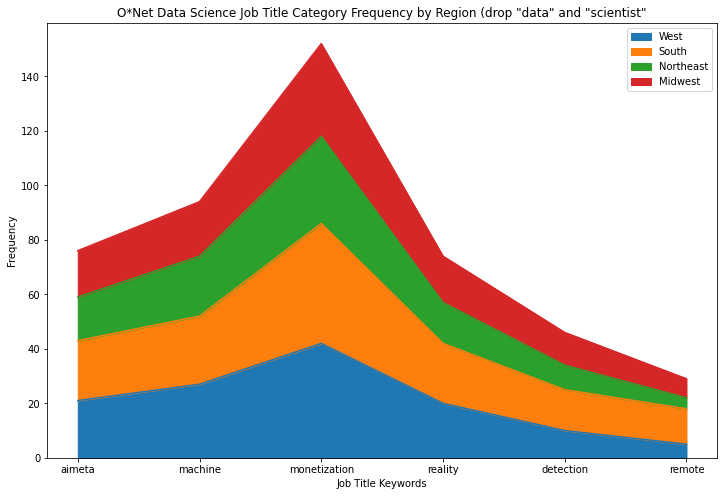

In [37]:
# Stacked Area Plot
region_drop_ds.plot(kind='area', stacked=True, legend=True, figsize=[12,8])
plt.xlabel('Job Title Keywords')
plt.ylabel('Frequency')
plt.title('O*Net Data Science Job Title Category Frequency by Region (drop "data" and "scientist"')

# Rotate x-axis tick labels by 45 degrees
#plt.xticks(rotation=45)
plt.savefig('Figures/regional_filtered_ds_job_title_category_area_plot.png')
plt.show()

### In the context of Natural Language Toolkit (NLTK) and text parsing, 'NN' and 'NNS' are part of the Penn Treebank tagset, which is a widely used set of tags for annotating parts of speech (POS) in text.

### In the Penn Treebank tagset, 'NN' stands for singular noun, and 'NNS' stands for plural noun. These tags are used to identify and label different types of nouns in a sentence.

### Here's a brief explanation of each tag:

### 'NN' (Noun, singular): It represents a singular noun, which refers to a person, place, thing, or idea. For example, in the sentence "The cat is sleeping," 'cat' would be tagged as 'NN'.

### 'NNS' (Noun, plural): It represents a plural noun, indicating that there are multiple instances of the noun. For example, in the sentence "The cats are sleeping," 'cats' would be tagged as 'NNS'.

### These POS tags are useful for understanding the grammatical structure of a sentence, performing text analysis, and implementing various natural language processing tasks. NLTK provides functionality to tokenize text and assign POS tags using different taggers, including the Penn Treebank tagger.